## SI

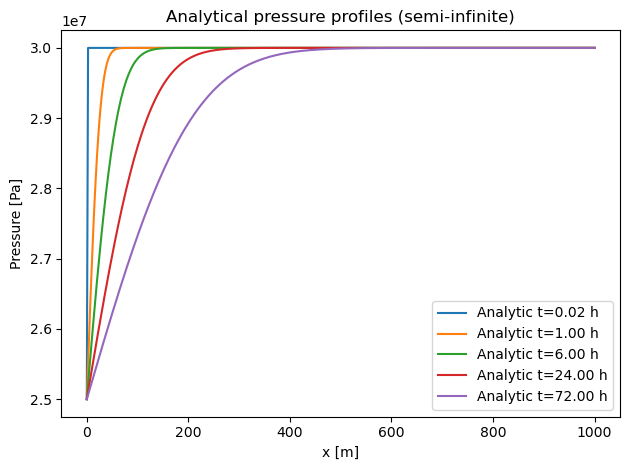

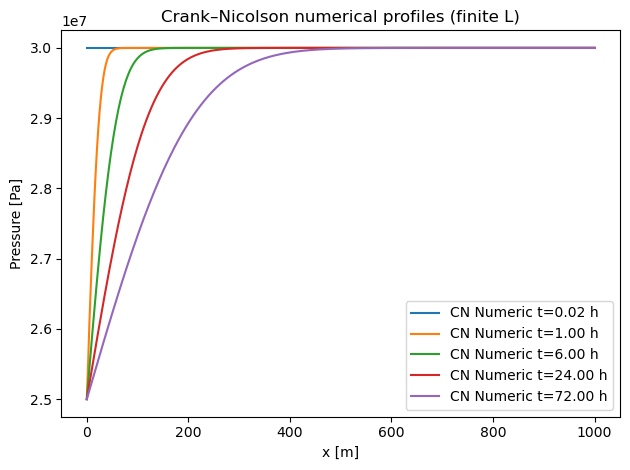

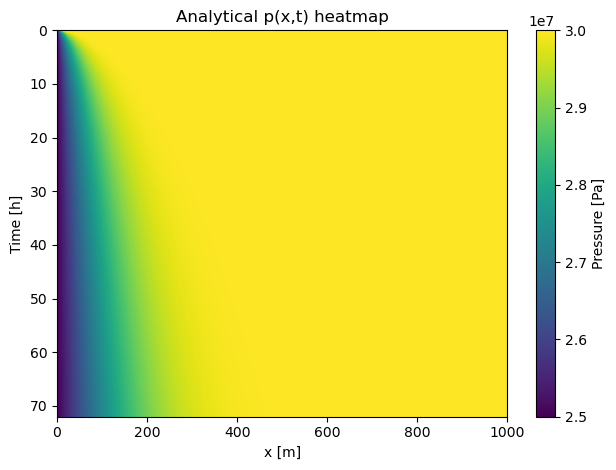

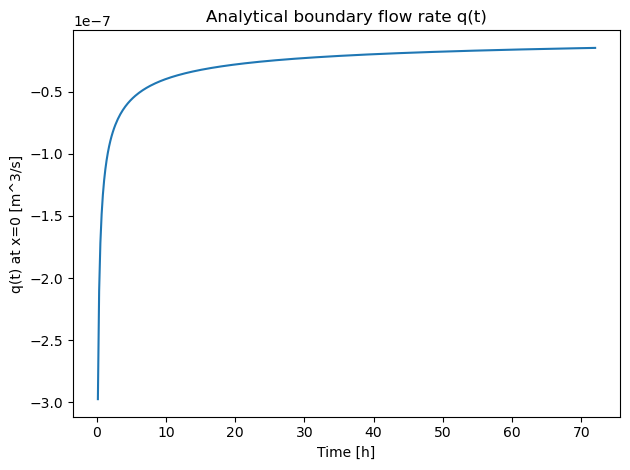

Saved CSV to: fracture_linearflow_px_t_profiles.csv


In [1]:
# Implementation: 1D fracture diffusion (pressure transient) with analytic & Crank–Nicolson numerical solution
# Assumptions follow your description (single-phase, slightly compressible, constant properties, semi-infinite frac approximated by finite L).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to import special functions for erf/erfc
try:
    from scipy.special import erf, erfc  # preferred (vectorized & fast)
except Exception:
    # Fallback to vectorized math.erf/erfc if SciPy isn't available
    import math
    erf = np.vectorize(math.erf)
    erfc = np.vectorize(math.erfc)

# -----------------------------
# 1) Physical parameters (SI)
# -----------------------------
k = 1e-14            # permeability [m^2] (~10 mD)
mu = 1e-3            # viscosity [Pa·s]
phi = 0.2            # porosity [-]
ct = 1e-9            # total compressibility [Pa^-1] (≈ 1e-5 psi^-1)   
p0 = 30e6            # initial pressure [Pa]
p1 = 25e6            # boundary pressure at x=0 for t>0 [Pa]

# Fracture geometry if you want boundary flow rate q(t) [m, m]
w = 3e-3             # fracture aperture (width) [m]
h = 20.0             # fracture height [m]
A = w * h            # cross-sectional area for 1D flow along fracture [m^2]

# Diffusivity (hydraulic) alpha = k / (mu * phi * ct)  [m^2/s]
alpha = k / (mu * phi * ct)

# -----------------------------
# 2) Numerical domain
# -----------------------------
L = 1000.0            # model length [m] (acts like "far field"; set large for semi-infinite)
nx = 401             # number of spatial nodes
dx = L / (nx - 1)

t_end = 3.0 * 24*3600   # simulate 3 days [s]
nt = 400                # time steps
dt = t_end / nt

x = np.linspace(0.0, L, nx)
t = np.linspace(0.0, t_end, nt+1)

# -----------------------------------------------
# 3) Analytical solution (semi-infinite, exact)
#     p(x,t) = p0 - (p0 - p1) * erfc( x / (2 sqrt(alpha t)) )
#     with p(x,0)=p0, p(0,t)=p1, p(∞,t)=p0
# -----------------------------------------------
def p_analytical(x_vals, time_vals):
    """Return p(x,t) on a grid using the semi-infinite analytic solution."""
    X, T = np.meshgrid(x_vals, time_vals, indexing="xy")
    P = np.full_like(X, p0, dtype=float)  # at t=0, p=p0
    # avoid divide-by-zero at t=0 by starting from t>0
    T_pos = np.maximum(T, 1e-30)
    z = X / (2.0 * np.sqrt(alpha * T_pos))
    P = p0 - (p0 - p1) * erfc(z)
    return P  # shape (len(time_vals), len(x_vals))

# -----------------------------------------------
# 4) Crank–Nicolson numerical solution on [0,L]
#     BCs: p(0,t)=p1 (Dirichlet), p(L,t)=p0 (Dirichlet ~ far-field)
#     IC:  p(x,0)=p0
# -----------------------------------------------
def crank_nicolson_1d(alpha, x, t, p_left, p_right, p_init):
    nx = len(x)
    nt = len(t) - 1
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    r = alpha * dt / (dx*dx)

    # Tridiagonal matrices A (LHS) and B (RHS): (I - r/2 * T) p^{n+1} = (I + r/2 * T) p^{n} + b
    # where T is the 1D Laplacian stencil
    main_A = (1 + r) * np.ones(nx)
    off_A = (-r/2) * np.ones(nx-1)
    main_B = (1 - r) * np.ones(nx)
    off_B = (r/2) * np.ones(nx-1)

    # Dirichlet BCs -> enforce at i=0 and i=nx-1 each step
    # We'll assemble tri-diagonal for interior points [1..nx-2]
    P = np.empty((nt+1, nx))
    P[0, :] = p_init

    # Pre-factorization via Thomas algorithm components for constant matrix A (interior)
    a = off_A.copy()  # subdiag (length nx-2)
    b = main_A.copy() # diag    (length nx)
    c = off_A.copy()  # super   (length nx-2)
    # keep only interior rows
    a_i = a[1-1: nx-2]
    b_i = b[1: nx-1].copy()
    c_i = c[0: nx-2]

    # Thomas forward coefficients
    c_star = np.zeros(nx-2)
    d_star = np.zeros(nx-2)

    for n in range(nt):
        rhs = np.zeros(nx-2)

        # Build RHS = B * p^n + BC contributions
        # interior update (i from 1..nx-2)
        rhs[:] = ( off_B[0:nx-2] * P[n, 0:nx-2] +
                   main_B[1:nx-1] * P[n, 1:nx-1] +
                   off_B[0:nx-2] * P[n, 2:nx] )

        # Dirichlet BC contribution
        rhs[0]  += (r/2) * p_left(t[n] + dt)   # left boundary at node i=0 contributes to i=1
        rhs[-1] += (r/2) * p_right(t[n] + dt)  # right boundary at node i=nx-1 contributes to i=nx-2

        # Thomas algorithm forward sweep
        c_star[0] = c_i[0] / b_i[0]
        d_star[0] = rhs[0] / b_i[0]
        for i in range(1, nx-2):
            denom = b_i[i] - a_i[i-1] * c_star[i-1]
            c_star[i] = c_i[i] / denom if i < nx-2 else 0.0
            d_star[i] = (rhs[i] - a_i[i-1] * d_star[i-1]) / denom

        # Back substitution
        P[n+1, 0]     = p_left(t[n] + dt)
        P[n+1, nx-1]  = p_right(t[n] + dt)
        P[n+1, nx-2]  = d_star[-1]
        for i in range(nx-4, -1, -1):  # i maps to interior index i+1
            P[n+1, i+1] = d_star[i] - c_star[i] * P[n+1, i+2]

    return P

# Helper boundary functions
def p_left_func(time_value):
    # Dirichlet at x=0: p = p1 for t>0; at t=0 it's still fine to set p1
    return p1

def p_right_func(time_value):
    # approximate semi-infinite: hold far field at initial pressure
    return p0

# Initial condition array
p_init = np.full_like(x, p0, dtype=float)

# Run numeric solver
P_num = crank_nicolson_1d(alpha, x, t, p_left_func, p_right_func, p_init)

# Analytic (for comparison)
P_ana = p_analytical(x, t)

# -----------------------------------------------
# 5) Boundary flow rate q(t) at x=0 (analytic)
#    q = -(k A / mu) * (∂p/∂x)|_{x=0}
#    ∂p/∂x|_{x=0} = (p0 - p1) / sqrt(pi * alpha * t) * exp(-0) = (p0-p1) / sqrt(pi*alpha*t)
#    => q(t) = -(k A / mu) * (p0 - p1) / sqrt(pi * alpha * t)
# -----------------------------------------------
t_pos = np.copy(t)
t_pos[0] = np.nan  # avoid divide by zero at t=0 (undefined/∞ slope)
q_t = -(k * A / mu) * (p0 - p1) / np.sqrt(np.pi * alpha * t_pos)

# -----------------------------------------------
# 6) Plots
# -----------------------------------------------
# Profile comparisons at selected times
times_to_plot = [60.0, 3600.0, 6*3600.0, 24*3600.0, 3*24*3600.0]  # 1 min, 1 h, 6 h, 1 d, 3 d
indices = [np.argmin(np.abs(t - tp)) for tp in times_to_plot]

plt.figure()
for idx, tp in zip(indices, times_to_plot):
    plt.plot(x, P_ana[idx, :], label=f"Analytic t={tp/3600:.2f} h")
plt.xlabel("x [m]")
plt.ylabel("Pressure [Pa]")
plt.title("Analytical pressure profiles (semi-infinite)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for idx, tp in zip(indices, times_to_plot):
    plt.plot(x, P_num[idx, :], label=f"CN Numeric t={tp/3600:.2f} h")
plt.xlabel("x [m]")
plt.ylabel("Pressure [Pa]")
plt.title("Crank–Nicolson numerical profiles (finite L)")
plt.legend()
plt.tight_layout()
plt.show()

# Heatmap of pressure (analytic)
plt.figure()
plt.imshow(P_ana, aspect='auto', extent=[x.min(), x.max(), t.max()/3600, t.min()/3600])
plt.colorbar(label="Pressure [Pa]")
plt.xlabel("x [m]")
plt.ylabel("Time [h]")
plt.title("Analytical p(x,t) heatmap")
plt.tight_layout()
plt.show()

# Boundary flow rate vs time
plt.figure()
plt.plot(t/3600.0, q_t)
plt.xlabel("Time [h]")
plt.ylabel("q(t) at x=0 [m^3/s]")
plt.title("Analytical boundary flow rate q(t)")
plt.tight_layout()
plt.show()

# -----------------------------------------------
# 7) Export a CSV of p(x,t) analytic & numeric (sparse for size)
# -----------------------------------------------
sample_idx_t = indices  # export the same selected times
df_rows = []
for idx in sample_idx_t:
    for xi, xv in enumerate(x):
        df_rows.append({
            "t_s": float(t[idx]),
            "x_m": float(xv),
            "p_analytic_Pa": float(P_ana[idx, xi]),
            "p_numeric_Pa": float(P_num[idx, xi])
        })
df = pd.DataFrame(df_rows)
csv_path = "fracture_linearflow_px_t_profiles.csv"
df.to_csv(csv_path, index=False)

print(f"Saved CSV to: {csv_path}")




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to import special functions for erf/erfc
try:
    from scipy.special import erf, erfc  # preferred (vectorized & fast)
except Exception:
    # Fallback to vectorized math.erf/erfc if SciPy isn't available
    import math
    erf = np.vectorize(math.erf)
    erfc = np.vectorize(math.erfc)


print(1-erf(1))
print(erfc(1))

0.15729920705028522
0.15729920705028516


## field

## ΔP v.s. distance

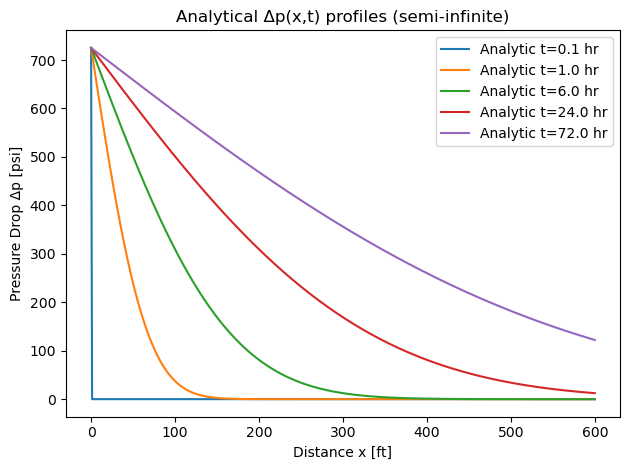

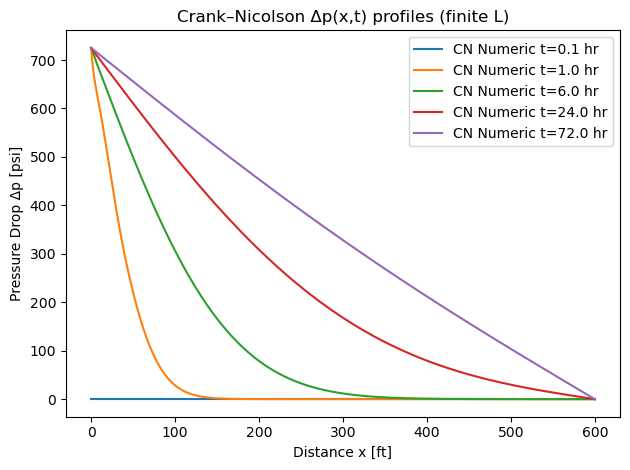

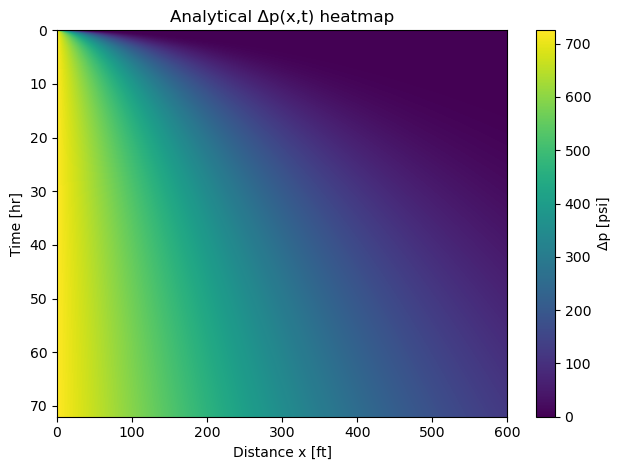

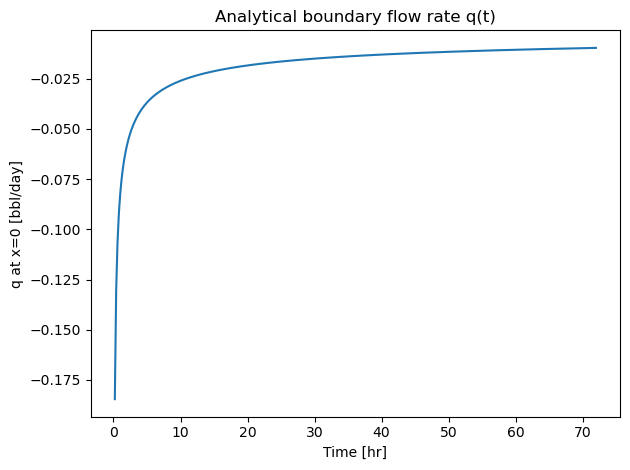

Saved CSV to: linearflow_field_units_deltaP.csv


In [ ]:
# Oilfield-units version (Δp outputs): 1D linear flow in a fracture
# Inputs in FIELD UNITS; internal math in SI. The plots/CSV report **pressure drop** Δp, not pressure.
# By default: Δp(x,t) = p0 - p(x,t) [psi]. You can also toggle a normalized drop Δp* = Δp/(p0-p1).
#
# What you'll get:
#   (1) Δp(x,t) profiles at selected times [psi vs ft] for analytic and CN numeric
#   (2) Heatmap of Δp(x,t) [psi]
#   (3) Boundary flow rate q(t) [bbl/day]
#   (4) CSV (field units) with Δp_analytic_psi and Δp_numeric_psi at selected times
#
# Libraries: numpy, matplotlib (no seaborn), pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Try SciPy erfc; fallback to math.erfc
try:
    from scipy.special import erfc
except Exception:
    import math
    erfc = np.vectorize(math.erfc)

# -----------------------------
# Unit conversions
# -----------------------------
md_to_m2   = 9.869233e-16
cp_to_Pas  = 1e-3
psi_to_Pa  = 6894.757293168361
ft_to_m    = 0.3048
inch_to_m  = 0.0254
bbl_to_m3  = 0.158987294928
sec_per_day = 86400.0

# -----------------------------
# Inputs (FIELD UNITS) — change here for your case
# -----------------------------
k_mD   = 80.0           # [mD]
mu_cP  = 0.185            # [cP]
phi    = 0.3           # [-]
ct_invpsi = 1.94e-5      # [1/psi]
p0_psi = 150         # [psi]
p1_psi = 0         # [psi]

w_in   = 0.12           # [in]
h_ft   = 65.0           # [ft]
L_ft   = 600.0          # [ft]

t_end_hr = 72.0         # [hr]
nt       = 360
nx       = 501

# Output options
times_to_plot_hr   = [0.1, 1.0, 6.0, 24.0, 72.0]
times_to_export_hr = times_to_plot_hr
use_normalized_drop = False  # if True, plots/export Δp* = (p0-p)/(p0-p1) in [-]

# -----------------------------
# Convert to SI
# -----------------------------
k   = k_mD * md_to_m2
mu  = mu_cP * cp_to_Pas
ct  = ct_invpsi / psi_to_Pa
p0  = p0_psi * psi_to_Pa
p1  = p1_psi * psi_to_Pa
w   = w_in * inch_to_m
h   = h_ft * ft_to_m
L   = L_ft * ft_to_m

alpha = k/(mu*phi*ct)  # [m^2/s]

# grids
x = np.linspace(0.0, L, nx)              # [m]
t = np.linspace(0.0, t_end_hr*3600.0, nt+1)  # [s]
x_ft = x/ft_to_m
t_hr = t/3600.0

# area for rate
A = w*h

# -----------------------------
# Analytic solution (semi-infinite), return Δp
# p(x,t) = p0 - (p0-p1) erfc( x / (2 sqrt(alpha t)) )
# so Δp = p0 - p = (p0 - p1) * erfc(...)
# -----------------------------
def delta_p_analytical_psi(x_vals_m, t_vals_s):
    X, T = np.meshgrid(x_vals_m, t_vals_s, indexing="xy")
    T_pos = np.maximum(T, 1e-30)
    z = X/(2.0*np.sqrt(alpha*T_pos))
    dp_si = (p0 - p1) * erfc(z)                # [Pa]
    return dp_si/psi_to_Pa                     # [psi]

Δp_ana_psi = delta_p_analytical_psi(x, t)

# Optional normalized drop
if use_normalized_drop:
    Δp_ana = Δp_ana_psi/(p0_psi - p1_psi)      # unitless
    ylabel_profiles = "Normalized Δp = (p0 - p)/(p0 - p1) [-]"
    colorbar_label = "Normalized Δp [-]"
else:
    Δp_ana = Δp_ana_psi
    ylabel_profiles = "Pressure Drop Δp [psi]"
    colorbar_label = "Δp [psi]"

# -----------------------------
# Crank–Nicolson numeric (finite L), return Δp
# -----------------------------
def crank_nicolson_1d(alpha, x, t, p_left, p_right, p_init):
    nx = len(x); nt = len(t)-1
    dx = x[1]-x[0]; dt = t[1]-t[0]
    r = alpha*dt/(dx*dx)

    main_A = (1+r)*np.ones(nx)
    off_A  = (-r/2)*np.ones(nx-1)
    main_B = (1-r)*np.ones(nx)
    off_B  = ( r/2)*np.ones(nx-1)

    P = np.empty((nt+1, nx))
    P[0,:] = p_init

    a_i = off_A[0:nx-2]
    b_i = main_A[1:nx-1].copy()
    c_i = off_A[0:nx-2]

    c_star = np.zeros(nx-2)
    d_star = np.zeros(nx-2)

    for n in range(nt):
        rhs = ( off_B[0:nx-2]*P[n,0:nx-2] +
                main_B[1:nx-1]*P[n,1:nx-1] +
                off_B[0:nx-2]*P[n,2:nx] )

        rhs[0]  += (r/2)*p_left(t[n]+dt)
        rhs[-1] += (r/2)*p_right(t[n]+dt)

        c_star[0] = c_i[0]/b_i[0]
        d_star[0] = rhs[0]/b_i[0]
        for i in range(1, nx-2):
            denom   = b_i[i] - a_i[i-1]*c_star[i-1]
            c_star[i] = c_i[i]/denom if i < nx-2 else 0.0
            d_star[i] = (rhs[i] - a_i[i-1]*d_star[i-1])/denom

        P[n+1,0]    = p_left(t[n]+dt)
        P[n+1,nx-1] = p_right(t[n]+dt)
        P[n+1,nx-2] = d_star[-1]
        for i in range(nx-4, -1, -1):
            P[n+1,i+1] = d_star[i] - c_star[i]*P[n+1,i+2]

    return P

def p_left_SI(time_val_s):  return p1
def p_right_SI(time_val_s): return p0

p_init_SI = np.full_like(x, p0, dtype=float)
P_num_SI  = crank_nicolson_1d(alpha, x, t, p_left_SI, p_right_SI, p_init_SI)
Δp_num_psi = (p0 - P_num_SI)/psi_to_Pa
Δp_num = Δp_num_psi/(p0_psi - p1_psi) if use_normalized_drop else Δp_num_psi

# -----------------------------
# Boundary flow rate q(t) [bbl/day], analytic
# -----------------------------
t_pos = np.copy(t); t_pos[0] = np.nan
q_m3s = -(k*A/mu) * (p0 - p1)/np.sqrt(np.pi*alpha*t_pos)
q_bpd = q_m3s * (sec_per_day/bbl_to_m3)

# -----------------------------
# Plots
# -----------------------------
idxs = [np.argmin(np.abs(t_hr - th)) for th in times_to_plot_hr]

# a) Analytic Δp profiles
plt.figure()
for idx, th in zip(idxs, times_to_plot_hr):
    plt.plot(x_ft, Δp_ana[idx,:], label=f"Analytic t={th:.1f} hr")
plt.xlabel("Distance x [ft]")
plt.ylabel(ylabel_profiles)
plt.title("Analytical Δp(x,t) profiles (semi-infinite)")
plt.legend()
plt.tight_layout()
plt.show()

# b) Numeric Δp profiles
plt.figure()
for idx, th in zip(idxs, times_to_plot_hr):
    plt.plot(x_ft, Δp_num[idx,:], label=f"CN Numeric t={th:.1f} hr")
plt.xlabel("Distance x [ft]")
plt.ylabel(ylabel_profiles)
plt.title("Crank–Nicolson Δp(x,t) profiles (finite L)")
plt.legend()
plt.tight_layout()
plt.show()

# c) Heatmap of Δp (analytic)
plt.figure()
plt.imshow(Δp_ana, aspect='auto',
           extent=[x_ft.min(), x_ft.max(), t_hr.max(), t_hr.min()])
plt.colorbar(label=colorbar_label)
plt.xlabel("Distance x [ft]")
plt.ylabel("Time [hr]")
plt.title("Analytical Δp(x,t) heatmap")
plt.tight_layout()
plt.show()

# d) q(t)
plt.figure()
plt.plot(t_hr, q_bpd)
plt.xlabel("Time [hr]")
plt.ylabel("q at x=0 [bbl/day]")
plt.title("Analytical boundary flow rate q(t)")
plt.tight_layout()
plt.show()

# -----------------------------
# Export CSV (field units) at selected times
# -----------------------------
rows = []
for th in times_to_export_hr:
    idx = np.argmin(np.abs(t_hr - th))
    for j, xj_ft in enumerate(x_ft):
        rows.append({
            "time_hr": float(t_hr[idx]),
            "x_ft": float(xj_ft),
            ("Δp_analytic_norm" if use_normalized_drop else "Δp_analytic_psi"): float(Δp_ana[idx, j]),
            ("Δp_numeric_norm"  if use_normalized_drop else "Δp_numeric_psi"):  float(Δp_num[idx, j])
        })
df = pd.DataFrame(rows)
csv_path = "linearflow_field_units_deltaP.csv"
df.to_csv(csv_path, index=False)


print(f"Saved CSV to: {csv_path}")


## ΔP v.s. time  *distance

In [5]:
from matplotlib import rc
from cycler import cycler

# Figure format
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符


      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

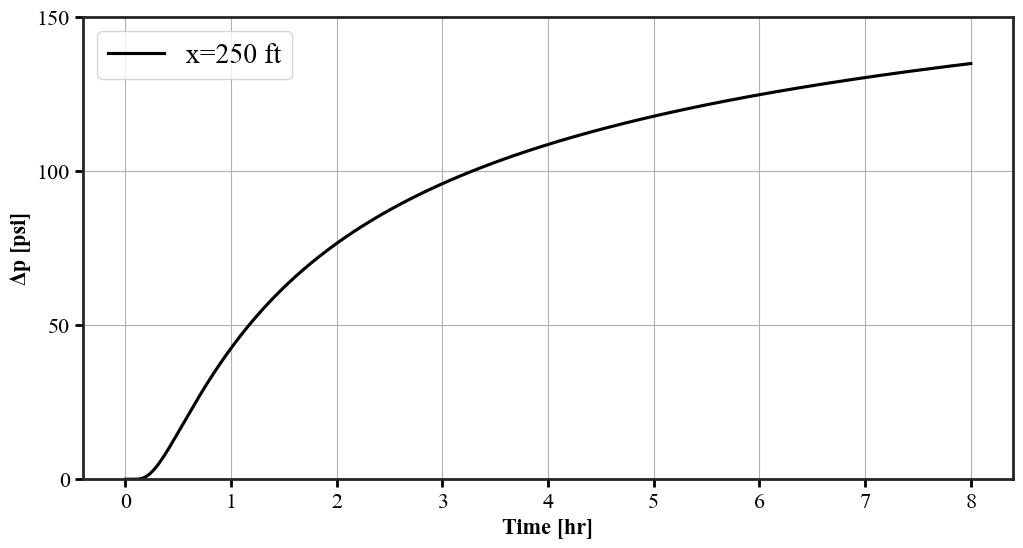

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# 单位换算
md_to_m2   = 9.869233e-16
cp_to_Pas  = 1e-3
psi_to_Pa  = 6894.757293168361
ft_to_m    = 0.3048

# 输入参数 (油田单位)
k_mD   = 80
mu_cP  = 0.185
phi    = 0.30
ct_invpsi = 1.94e-5
p0_psi = 206
p1_psi = 0

# 转为 SI
k   = k_mD * md_to_m2
mu  = mu_cP * cp_to_Pas
ct  = ct_invpsi / psi_to_Pa
p0  = p0_psi * psi_to_Pa
p1  = p1_psi * psi_to_Pa

alpha = k/(mu*phi*ct)

# 时间轴 [hr]
t_end_hr = 8
nt = 3600
t = np.linspace(0, t_end_hr*3600, nt+1)
t_hr = t/3600

# 观测点 [ft]
x_locs_ft = [250]
x_locs_m  = [xf * ft_to_m for xf in x_locs_ft]

# 计算 Δp
Δp_curves = {}
for xf_ft, xf_m in zip(x_locs_ft, x_locs_m):
    T_pos = np.maximum(t, 1e-30)
    z = xf_m/(2*np.sqrt(alpha*T_pos))
    dp = (p0 - p1)*erfc(z) / psi_to_Pa
    Δp_curves[xf_ft] = dp

# 画图 Δp vs time
plt.figure(figsize=(12, 6))
for xf_ft in x_locs_ft:
    plt.plot(t_hr, Δp_curves[xf_ft], label=f"x={xf_ft} ft")
plt.xlabel("Time [hr]", fontsize=16)
plt.ylim(0, 150)          # 设置 y 轴范围
plt.yticks(range(0, 151, 50))  # 设置刻度间隔（0 到 1500，步长 500）
plt.ylabel("Δp [psi]", fontsize=16)
# plt.title("Pressure drop vs time at different distances")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.legend()
plt.show()


## ΔP v.s. time  *permeability

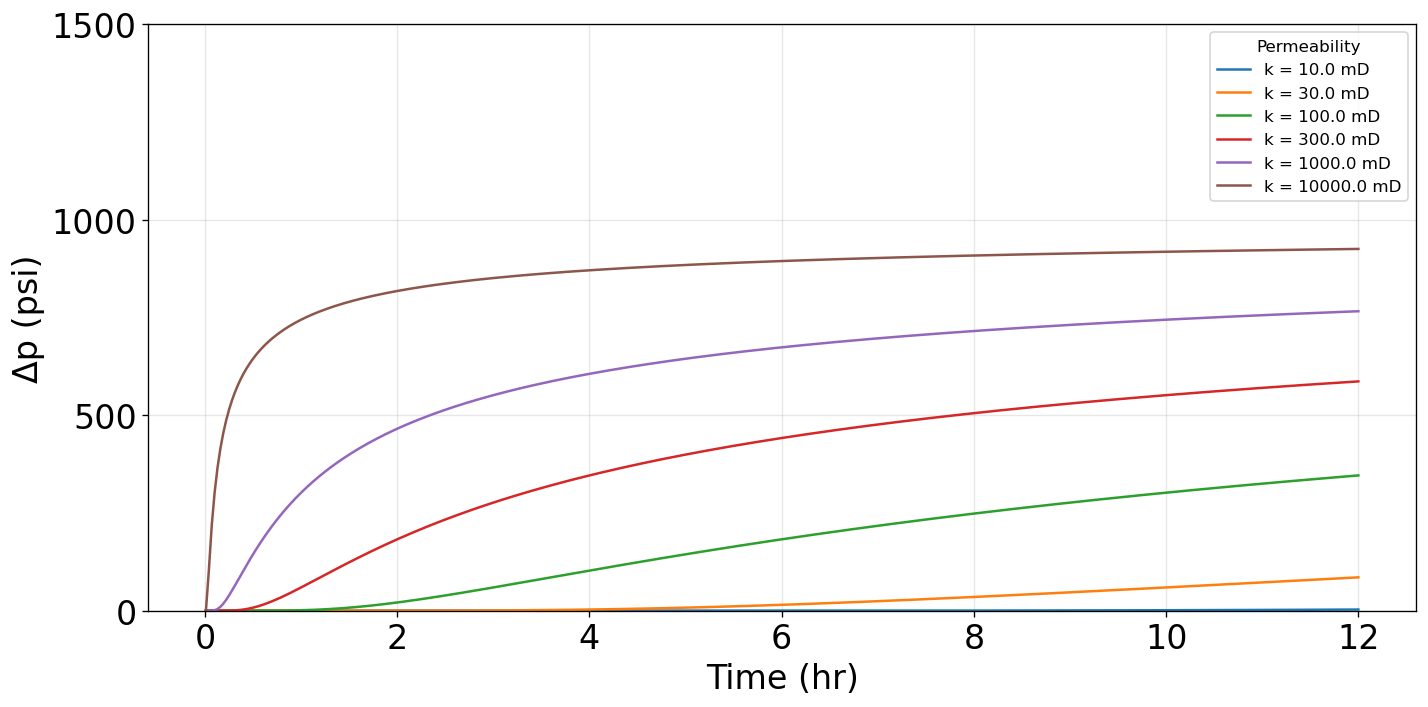

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from math import erf, sqrt

# --- 单位换算常数（油田 -> SI） ---
MD_TO_M2 = 9.869233e-16        # mD -> m^2
CP_TO_PA_S = 1e-3              # cP -> Pa·s
PSI_TO_PA = 6894.757293        # psi -> Pa
FT_TO_M = 0.3048               # ft -> m
HR_TO_S = 3600.0               # hr -> s

def delta_p_erf_field_units(x_ft, t_hr, k_mD, mu_cP, phi, ct_per_psi, p0_psi, p1_psi):
    """
    计算 Δp(x,t)（单位：psi）
    基于 Δp = (p0 - p1) * [1 - erf( x / sqrt(4 * a * t) )], 其中 a = k/(mu*phi*ct)
    输入均为油田常用单位；内部自动换算到 SI。
    """
    # 参数换算到 SI
    x = x_ft * FT_TO_M                          # m
    t = np.asarray(t_hr) * HR_TO_S              # s
    k = k_mD * MD_TO_M2                         # m^2
    mu = mu_cP * CP_TO_PA_S                     # Pa·s
    ct = ct_per_psi / PSI_TO_PA                 # 1/Pa

    a = k / (mu * phi * ct)                     # m^2/s  (扩散率)

    # 避免 t=0 导致除零，做个最小时间截断
    t = np.maximum(t, 1e-12)

    arg = x / np.sqrt(4.0 * a * t)
    delta_p = (p0_psi - p1_psi) * (1.0 - np.vectorize(erf)(arg))  # psi
    return delta_p

# ------------------ 可修改的物理参数（油田单位） ------------------
phi = 0.30                 # 孔隙度 (无量纲)
mu_cP = 3                # 黏度 (cP)
ct_per_psi = 1.0e-5        # 总压缩系数 (1/psi)
p0_psi = 4000.0            # 初始压力 p0 (psi)
p1_psi = 3000.0            # 边界压力 p1 (psi)
x_ft = 250.0               # 计算位置 x (ft) —— 可改
frc_with = 0.12            # 裂缝宽度 (in)

#conductivity series
con_mDft = [0.1, 0.3, 1, 3, 10, 100]
con_mDft = np.array(con_mDft)

# 渗透率系列 (mD) —— 敏感性分析
# k_series_mD = [10, 25, 50, 100, 200, 500]
k_series_mD =  con_mDft / (frc_with/12)  # 转为 mD

# 时间 (hr)
t_hr = np.linspace(0.01, 12, 400)  # 避免 t=0

# ------------------ 作图 ------------------
plt.figure(figsize=(12, 6), dpi=120)

for k_mD in k_series_mD:
    dp = delta_p_erf_field_units(
        x_ft=x_ft,
        t_hr=t_hr,
        k_mD=k_mD,
        mu_cP=mu_cP,
        phi=phi,
        ct_per_psi=ct_per_psi,
        p0_psi=p0_psi,
        p1_psi=p1_psi
    )
    plt.plot(t_hr, dp, label=f'k = {k_mD} mD')

plt.xlabel("Time (hr)",fontsize=20)
plt.ylabel("Δp (psi)",fontsize=20)
# plt.title(f"Δp vs Time at x = {x_ft:.0f} ft (erf model)")
plt.legend(title="Permeability")
plt.grid(True, alpha=0.3)

# 需要固定坐标范围和刻度间隔的话，取消注释并按需调整：
# plt.xlim(0, 48)
# plt.xticks(np.arange(0, 49, 6))
plt.ylim(0, 1500)
plt.yticks(np.arange(0, 1501, 500))
#刻度字体大小
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()
